In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV
# from sklearn.datasets import make_regression
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder  

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from sklearn import svm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# import random

In [2]:
df = pd.read_csv('../../../../Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')

In [3]:
# Inspect all labels in the dataset
counts = df[' Label'].value_counts()
print(counts)

 Label
BENIGN          288566
Infiltration        36
Name: count, dtype: int64


In [4]:
# Preprocessing: Remove all rows with NaN or inf values

# Count rows with at least one NaN value
nan_rows_indices = df.index[df.isna().any(axis=1)].tolist()
nan_rows_count = len(nan_rows_indices)
print("Number of rows with at least one NaN value:", nan_rows_count)

# Exclude last column because it has strings and the check for inf numbers throws an error
X = df.iloc[:, 0:-1]

# Count rows with at least one infinite value
inf_rows_indices = X.index[np.isinf(X).any(axis=1)].tolist()
inf_rows_count = len(inf_rows_indices)
print("Number of rows with at least one inf value:", inf_rows_count)

# Combine indices of rows with NaN or inf values
rows_to_drop = set(nan_rows_indices + inf_rows_indices)

# Drop rows with at least one NaN or inf value
df2 = df.drop(index=rows_to_drop)

Number of rows with at least one NaN value: 18
Number of rows with at least one inf value: 207


In [5]:
# Give all samples with a non BENIGN label the label MALICIOUS
df2[' Label'] = df2[' Label'].where(df2[' Label'] == 'BENIGN', 'MALICIOUS')

label_counts = df2[' Label'].value_counts()
print(label_counts)

 Label
BENIGN       288359
MALICIOUS        36
Name: count, dtype: int64


In [6]:
# Make the labels numerical
df2[' Label'] = df2[' Label'].replace({'BENIGN': 0, 'MALICIOUS': 1})

In [7]:
# Split dataset into features and labels
X_original = df2.iloc[:,0:-1]
y_original = df2.iloc[:, -1]

In [8]:
# Transform the features to only have a range [0, 1]. Note that the scaled data are now a numpy array, not a df
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_original)

# Print the range of values in the scaled dataframe
# print(X_scaled.describe().loc[['min', 'max']])
print(X_scaled.max(axis=None))
print(X_scaled.min(axis=None))

1.0
0.0


In [9]:
# Print the count of 0s and 1s. It should match the numbers for 'MALICIOUS' and 'BENIGN'
unique_values, counts = np.unique(y_original, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 288359
Value: 1, Count: 36


In [10]:
benign_indices = y_original.index[y_original == 1].tolist()
print(len(y_original[benign_indices]))

36


In [11]:
len(y_original)

288395

In [12]:
# Function to split dataset into training and testing data
def data_split(X=X_scaled, y=y_original, test_ratio=0.3):

    # X is already an array from when we normalized the numbers between 0 and 1.
    # Convert y to an array too.
    y = y.to_numpy()

    # Extract indices of each of the two classes in the dataframe 
    benign_indices = np.where(y == 0)[0]
    malicious_indices = np.where(y == 1)[0]

    # Shuffle array and sample the indices according to the specified test_ratio
    np.random.shuffle(benign_indices)
    np.random.shuffle(malicious_indices)

    index_benign = int(test_ratio * len(benign_indices))
    index_malicious = int(test_ratio * len(malicious_indices))

    benign_indices_test = benign_indices[:index_benign]
    malicious_indices_test = malicious_indices[:index_malicious]

    benign_indices_train = benign_indices[index_benign:]
    malicious_indices_train = malicious_indices[index_malicious:]

    X_train = X[np.concatenate((benign_indices_train, malicious_indices_train)), :]
    X_test = X[np.concatenate((benign_indices_test, malicious_indices_test)), :]
    y_train = y[np.concatenate((benign_indices_train, malicious_indices_train))]
    y_test = y[np.concatenate((benign_indices_test, malicious_indices_test))]

    return X_train, X_test, y_train, y_test

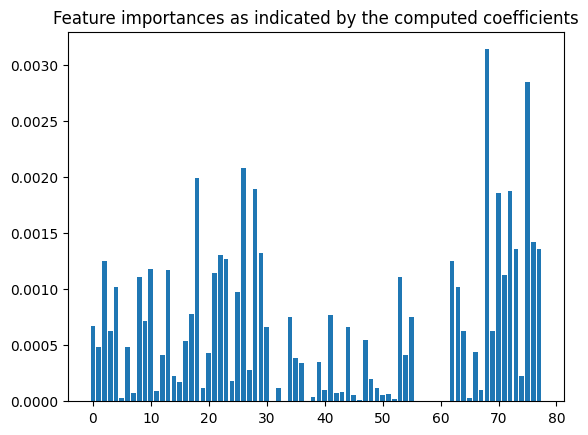

In [13]:
# Feature selection

# Fit RidgeCV model
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_scaled, y_original)

# Plot feature importances via coefficients
importance = np.abs(ridge.coef_)
# feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
features = [i for i in range(X.shape[1])]
plt.bar(height=importance, x=features)
plt.title("Feature importances as indicated by the computed coefficients")

plt.show()

In [14]:
print(type(importance))

<class 'numpy.ndarray'>


In [15]:
"""
# Select the most important features
threshold = 0.001
selected_features = []

# Set a threshold above which we deem a feature important
for feature, importance_score in zip(features, importance):
    if importance_score > threshold:
        selected_features.append(feature)

"""

'\n# Select the most important features\nthreshold = 0.001\nselected_features = []\n\n# Set a threshold above which we deem a feature important\nfor feature, importance_score in zip(features, importance):\n    if importance_score > threshold:\n        selected_features.append(feature)\n\n'

In [16]:
# X_train, X_test, y_train, y_test = data_split(X_scaled, y_original) 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_original, random_state=42, test_size=0.2)
print(len(X_scaled))
print(len(y_original))

print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

288395
288395
230716
230716
57679
57679


In [17]:
# # Data augmentation technique one: SMOTEENN
# print('Total data before augmentation %s' % Counter(y_original))
# sme = SMOTEENN()
# X_augmented_smoteenn, y_augmented_smoteenn = sme.fit_resample(X_train, y_train)
# print('Total Data after SMOTEENN augmentation %s' % Counter(y_augmented_smoteenn))

# # Data augmentation technique one: ADASYN
# adasyn = ADASYN()
# X_augmented_ada, y_augmented_ada = adasyn.fit_resample(X_train, y_train)
# print('Total Data after ADASYN augmentation %s' % Counter(y_augmented_smoteenn))


In [20]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Build the RNN model
model = Sequential()
# model.add(Embedding(input_dim=X_train.shape[1], output_dim=64, input_length=X_train.shape[1]))
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(SimpleRNN(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))




Epoch 1/10


5768/5768 [==============================] - 26s 4ms/step - loss: 0.1430 - accuracy: 0.9998 - val_loss: 0.0016 - val_accuracy: 0.9999
Epoch 2/10
5768/5768 [==============================] - 26s 4ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.0017 - val_accuracy: 0.9999
Epoch 3/10
5768/5768 [==============================] - 27s 5ms/step - loss: 0.0068 - accuracy: 0.9999 - val_loss: 0.0053 - val_accuracy: 0.9999
Epoch 4/10
5768/5768 [==============================] - 27s 5ms/step - loss: 0.0065 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9999
Epoch 5/10
5768/5768 [==============================] - 26s 4ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.0013 - val_accuracy: 0.9999
Epoch 6/10
5768/5768 [==============================] - 26s 4ms/step - loss: 0.0073 - accuracy: 0.9999 - val_loss: 0.0153 - val_accuracy: 0.9999
Epoch 7/10
5768/5768 [==============================] - 26s 5ms/step - loss: 0.0022 - accuracy: 0.9999 - val_loss: 0.0011 - val

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
# Select best model and perform feature selection on it to check if it improves performance

In [ ]:
# Hyperparameter tuning?